In [1]:
# import numpy as np
# import torch
# from torch.utils.data import Dataset, DataLoader, Subset
# from sklearn.cluster import AgglomerativeClustering
# import random
# from torch import nn, optim
# import torch.nn.functional as F
# import os
# from torchvision import datasets, transforms

# # Set random seed
# torch.manual_seed(43)
# np.random.seed(43)
# device = "cuda" if torch.cuda.is_available() else "cpu"

# mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7'], dtype='<U1')

# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3, 16, kernel_size=3),
#             nn.BatchNorm2d(16),
#             nn.ReLU())

#         self.layer2 = nn.Sequential(
#             nn.Conv2d(16, 16, kernel_size=3),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))

#         self.layer3 = nn.Sequential(
#             nn.Conv2d(16, 64, kernel_size=3),
#             nn.BatchNorm2d(64),
#             nn.ReLU())
        
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=3),
#             nn.BatchNorm2d(64),
#             nn.ReLU())

#         self.layer5 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))

#         self.fc = nn.Sequential(
#             nn.Linear(64 * 4 * 4, 128),
#             nn.ReLU(),
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Linear(128, 8))

#     def forward(self, x):
#         # 调整输入数据形状为 [batch_size, channels, height, width]
#         if x.dim() == 4 and x.size(1) != self.layer1[0].in_channels:
#             x = x.permute(0, 3, 1, 2)
        
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = self.layer5(x)
#         x = x.reshape(x.size(0), -1)  # 使用 reshape 替换 view
#         x = self.fc(x)
#         return x

# # Define dataset class
# class BloodMNISTDataset(Dataset):
#     def __init__(self, data_file, transform=None):
#         # Load data file
#         data = np.load(data_file)
#         print(data.files)
#         self.images = data['train_images']  # Modified from 'x' to 'train_images'
#         self.labels = np.squeeze(data['train_labels'])  # Modified from 'y' to 'train_labels', added squeeze
#         self.transform = transform

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         image = self.images[idx]
#         label = self.labels[idx]
#         if self.transform:
#             image = self.transform(image)
#         return image, label

# # Define data transformation
# transform = transforms.Compose([
#     transforms.ToTensor(),  # Convert to tensor
#     transforms.Normalize((0.5,), (0.5,))  # Normalize
# ])

# # Load dataset
# data_file = r"C:\Users\pj\Desktop\zy\PFL-Non-IID-master\dataset\BloodMNIST_0.1\rawdata\bloodmnist.npz"  # Local file path
# dataset = BloodMNISTDataset(data_file, transform=transform)

# # Splitting training set and testing set
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# # Get the indices of the training set and test set
# train_idcs = np.arange(len(train_dataset))
# test_idcs = np.arange(len(test_dataset))

# # Randomly shuffle the training set indices
# np.random.shuffle(train_idcs)

# # Get training labels
# train_labels = np.array([dataset[i][1] for i in train_idcs])

# # Define a non-iid split function
# def split_noniid(train_idcs, train_labels, alpha, n_clients):
#     n_classes = np.max(train_labels) + 1
#     label_distribution = np.random.dirichlet([alpha] * n_clients, n_classes)

#     class_idcs = [np.argwhere(train_labels[train_idcs] == y).flatten()
#                   for y in range(n_classes)]

#     client_idcs = [[] for _ in range(n_clients)]
#     for c, fracs in zip(class_idcs, label_distribution):
#         for i, idcs in enumerate(np.split(c, (np.cumsum(fracs)[:-1] * len(c)).astype(int))):
#             client_idcs[i] += [idcs]

#     client_idcs = [train_idcs[np.concatenate(idcs)] for idcs in client_idcs]

#     return client_idcs

# # Define a custom subset class
# class CustomSubset(Subset):
#     def __init__(self, dataset, indices, subset_transform=None):
#         super().__init__(dataset, indices)
#         self.subset_transform = subset_transform

#     def __getitem__(self, idx):
#         x, y = self.dataset[self.indices[idx]]

#         if self.subset_transform:
#             x = self.subset_transform(x)

#         return x, y

# # Define client and server classes
# class FederatedTrainingDevice(object):
#     def __init__(self, model_fn, data):
#         self.model = model_fn().to(device)
#         self.data = data
#         self.W = {key : value for key, value in self.model.named_parameters()}

#     def evaluate(self, loader=None):
#         return eval_op(self.model, self.eval_loader if not loader else loader)


# class Client(FederatedTrainingDevice):
#     def __init__(self, model_fn, optimizer_fn, data, idnum, batch_size=128, train_frac=0.8):
#         super().__init__(model_fn, data)
#         self.optimizer = optimizer_fn(self.model.parameters())

#         self.data = data
#         n_train = int(len(data)*train_frac)
#         n_eval = len(data) - n_train
#         data_train, data_eval = torch.utils.data.random_split(self.data, [n_train, n_eval])

#         self.train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
#         self.eval_loader = DataLoader(data_eval, batch_size=batch_size, shuffle=False)

#         self.id = idnum

#         self.dW = {key : torch.zeros_like(value) for key, value in self.model.named_parameters()}
#         self.W_old = {key : torch.zeros_like(value) for key, value in self.model.named_parameters()}

#     def synchronize_with_server(self, server):
#         copy(target=self.W, source=server.W)

#     def compute_weight_update(self, epochs=1, loader=None):
#         copy(target=self.W_old, source=self.W)
#         self.optimizer.param_groups[0]["lr"]*=0.99
#         train_stats = train_op(self.model, self.train_loader if not loader else loader, self.optimizer, epochs)
#         subtract_(target=self.dW, minuend=self.W, subtrahend=self.W_old)#计算梯度更新量
#         return train_stats

#     def reset(self):
#         copy(target=self.W, source=self.W_old)

# def mean_without_zeros(arr):
#     # 创建一个布尔掩码，将0值替换为NaN，非0值保留原值
#     masked_arr = np.where(arr == 0, np.nan, arr)
#     # 使用nanmean计算均值，这会自动忽略NaN值
#     mean_values = np.nanmean(masked_arr, axis=1)
#     return mean_values

# class ExperimentLogger:
#     def log(self, values):
#         for k, v in values.items():
#             if k not in self.__dict__:
#                 self.__dict__[k] = [v]
#             else:
#                 self.__dict__[k] += [v]

# def highlight_max(s):
#     global max_values
#     is_max = s == s.max()
#     max_values.append(s.max())  # 将最大值添加到列表中
#     return ['background-color: yellow' if v else '' for v in is_max]

# def display_train_stats(res_mean,res_std, cfl_stats, eps_1, eps_2, communication_rounds):
#     clear_output(wait=True)

#     acc_mean = np.mean(cfl_stats.acc_clients, axis=1)
#     print(acc_mean)
#     res_mean=acc_mean
#     acc_std = np.std(cfl_stats.acc_clients, axis=1)
#     print(acc_std)

#     res_std=acc_std
#     plt.fill_between(cfl_stats.rounds, acc_mean-acc_std, acc_mean+acc_std, alpha=0.5, color="C0")
#     plt.plot(cfl_stats.rounds, acc_mean, color="C0")

#     if "split" in cfl_stats.__dict__:
#        for s in cfl_stats.split:
#            plt.axvline(x=s, linestyle="-", color="k", label=r"Split")

#     plt.xlabel("Communication Rounds")
#     plt.ylabel("Accuracy")

#     plt.xlim(0, communication_rounds)
#     plt.ylim(0,1)
#     plt.legend()

#     plt.xlim(0, communication_rounds)

#     plt.show()
#     return res_mean,res_std


# def train_op(model, loader, optimizer, epochs=1):
#     model.train()
#     for ep in range(epochs):
#         running_loss, samples = 0.0, 0
#         for x, y in loader:
#             x, y = x.to(device), y.to(device)
#             optimizer.zero_grad()

#             loss = torch.nn.CrossEntropyLoss()(model(x), y)
#             running_loss += loss.item()*y.shape[0]
#             samples += y.shape[0]

#             loss.backward()
#             optimizer.step()

#     return running_loss / samples

# def eval_op(model, loader):
#     model.train()
#     samples, correct = 0, 0

#     with torch.no_grad():
#         for i, (x, y) in enumerate(loader):
#             x, y = x.to(device), y.to(device)

#             y_ = model(x)
#             _, predicted = torch.max(y_.data, 1)

#             samples += y.shape[0]
#             correct += (predicted == y).sum().item()
#     return correct/samples

# def copy(target, source):
#     for name in target:
#         target[name].data = source[name].data.clone()

# def subtract_(target, minuend, subtrahend):
#     for name in target:
#         target[name].data = minuend[name].data.clone()-subtrahend[name].data.clone()

# def reduce_add_average(targets, sources):
#     for target in targets:
#         for name in target:
#             tmp = torch.mean(torch.stack([source[name].data for source in sources]), dim=0).clone()
#             target[name].data += tmp

# def flatten(source):
#     return torch.cat([value.flatten() for value in source.values()])

# def pairwise_angles(sources):
#     angles = torch.zeros([len(sources), len(sources)])
#     for i, source1 in enumerate(sources):
#         for j, source2 in enumerate(sources):
#             s1 = flatten(source1)
#             s2 = flatten(source2)
#             angles[i,j] = torch.sum(s1*s2)/(torch.norm(s1)*torch.norm(s2)+1e-12)

#     return angles.numpy()

# class Server(FederatedTrainingDevice):
#     def __init__(self, model_fn, data):
#         super().__init__(model_fn, data)
#         self.loader = DataLoader(self.data, batch_size=128, shuffle=False)
#         self.model_cache = []

#     def select_clients(self, clients, frac=1.0):
#         return random.sample(clients, int(len(clients)*frac))

#     def aggregate_weight_updates(self, clients):
#         reduce_add_average(target=self.W, sources=[client.dW for client in clients])

#     def compute_pairwise_similarities(self, clients):
#         return pairwise_angles([client.dW for client in clients])

#     def cluster_clients(self, S): #聚类算法 可以修改
#         clustering = AgglomerativeClustering(affinity="precomputed", linkage="complete").fit(-S)

#         c1 = np.argwhere(clustering.labels_ == 0).flatten()
#         c2 = np.argwhere(clustering.labels_ == 1).flatten()
#         return c1, c2

#     def aggregate_clusterwise(self, client_clusters):
#         for cluster in client_clusters:
#             reduce_add_average(targets=[client.W for client in cluster],
#                                sources=[client.dW for client in cluster])

#     def compute_max_update_norm(self, cluster):
#         return np.max([torch.norm(flatten(client.dW)).item() for client in cluster])

#     def compute_mean_update_norm(self, cluster):
#         return torch.norm(torch.mean(torch.stack([flatten(client.dW) for client in cluster]),dim=0)).item()

#     def cache_model(self, idcs, params, accuracies):
#         self.model_cache += [(idcs,{name : params[name].data.clone() for name in params},[accuracies[i] for i in idcs])]


# # Initialize the client and server
# N_CLIENTS = 10
# DIRICHLET_ALPHA = 2

# client_idcs = split_noniid(train_idcs, train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)
# client_data = [CustomSubset(train_dataset, idcs) for idcs in client_idcs]
# test_data = CustomSubset(test_dataset, test_idcs)

# server = Server(ConvNet, test_data)

In [2]:
# import numpy as np
# import torch
# from torch.utils.data import Dataset, DataLoader, Subset
# from sklearn.cluster import AgglomerativeClustering
# import random
# from torch import nn, optim
# import torch.nn.functional as F
# import os
# from torchvision import datasets, transforms

# # Set random seed
# torch.manual_seed(43)
# np.random.seed(43)
# device = "cuda" if torch.cuda.is_available() else "cpu"

# mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7'], dtype='<U1')

# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3, 16, kernel_size=3),
#             nn.BatchNorm2d(16),
#             nn.ReLU())

#         self.layer2 = nn.Sequential(
#             nn.Conv2d(16, 16, kernel_size=3),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))

#         self.layer3 = nn.Sequential(
#             nn.Conv2d(16, 64, kernel_size=3),
#             nn.BatchNorm2d(64),
#             nn.ReLU())
        
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=3),
#             nn.BatchNorm2d(64),
#             nn.ReLU())

#         self.layer5 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))

#         self.fc = nn.Sequential(
#             nn.Linear(64 * 4 * 4, 128),
#             nn.ReLU(),
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Linear(128, 8))

#     def forward(self, x):
#         # 调整输入数据形状为 [batch_size, channels, height, width]
#         if x.dim() == 4 and x.size(1) != self.layer1[0].in_channels:
#             x = x.permute(0, 3, 1, 2)
        
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = self.layer5(x)
#         x = x.reshape(x.size(0), -1)  # 使用 reshape 替换 view
#         x = self.fc(x)
#         return x

# # Define dataset class
# class BloodMNISTDataset(Dataset):
#     def __init__(self, data_file, transform=None):
#         # Load data file
#         data = np.load(data_file)
#         print("Data files:", data.files)
#         self.images = data['train_images']  # Modified from 'x' to 'train_images'
#         self.labels = np.squeeze(data['train_labels'])  # Modified from 'y' to 'train_labels', added squeeze
#         print("Images shape:", self.images.shape)
#         print("Labels shape:", self.labels.shape)
#         print("Images type:", type(self.images))
#         print("Labels type:", type(self.labels))
#         self.transform = transform

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         image = self.images[idx]
#         label = self.labels[idx]
#         if self.transform:
#             image = self.transform(image)
#         print("Image shape:", image.shape)
#         print("Label:", label)
#         return image, label

# # Define data transformation
# transform = transforms.Compose([
#     transforms.ToTensor(),  # Convert to tensor
#     transforms.Normalize((0.5,), (0.5,))  # Normalize
# ])

# # Load dataset
# data_file = r"C:\Users\pj\Desktop\zy\PFL-Non-IID-master\dataset\BloodMNIST_0.1\rawdata\bloodmnist.npz"  # Local file path
# dataset = BloodMNISTDataset(data_file, transform=transform)

# # Splitting training set and testing set
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# print("Train dataset type:", type(train_dataset))
# print("Test dataset type:", type(test_dataset))
# print("Train dataset length:", len(train_dataset))
# print("Test dataset length:", len(test_dataset))

# # Get the indices of the training set and test set
# train_idcs = np.arange(len(train_dataset))
# test_idcs = np.arange(len(test_dataset))

# print("Train indices shape:", train_idcs.shape)
# print("Test indices shape:", test_idcs.shape)

# # Randomly shuffle the training set indices
# np.random.shuffle(train_idcs)

# # Get training labels
# train_labels = np.array([dataset[i][1] for i in train_idcs])

# print("Train labels shape:", train_labels.shape)
# print("Train labels type:", type(train_labels))

# # Define a non-iid split function
# def split_noniid(train_idcs, train_labels, alpha, n_clients):
#     n_classes = np.max(train_labels) + 1
#     label_distribution = np.random.dirichlet([alpha] * n_clients, n_classes)
#     print("Label distribution shape:", label_distribution.shape)

#     class_idcs = [np.argwhere(train_labels[train_idcs] == y).flatten()
#                   for y in range(n_classes)]
#     for y, c in enumerate(class_idcs):
#         print(f"Class {y} indices shape:", c.shape)

#     client_idcs = [[] for _ in range(n_clients)]
#     for c, fracs in zip(class_idcs, label_distribution):
#         for i, idcs in enumerate(np.split(c, (np.cumsum(fracs)[:-1] * len(c)).astype(int))):
#             client_idcs[i] += [idcs]
#     for i, idcs in enumerate(client_idcs):
#         print(f"Client {i} indices shape before concatenation:", [ids.shape for ids in idcs])

#     client_idcs = [train_idcs[np.concatenate(idcs)] for idcs in client_idcs]
#     for i, idcs in enumerate(client_idcs):
#         print(f"Client {i} indices shape after concatenation:", idcs.shape)

#     return client_idcs

# # Define a custom subset class
# class CustomSubset(Subset):
#     def __init__(self, dataset, indices, subset_transform=None):
#         super().__init__(dataset, indices)
#         self.subset_transform = subset_transform

#     def __getitem__(self, idx):
#         x, y = self.dataset[self.indices[idx]]

#         if self.subset_transform:
#             x = self.subset_transform(x)

#         return x, y

# # Define client and server classes
# class FederatedTrainingDevice(object):
#     def __init__(self, model_fn, data):
#         self.model = model_fn().to(device)
#         self.data = data
#         self.W = {key : value for key, value in self.model.named_parameters()}

#     def evaluate(self, loader=None):
#         return eval_op(self.model, self.eval_loader if not loader else loader)

# class Client(FederatedTrainingDevice):
#     def __init__(self, model_fn, optimizer_fn, data, idnum, batch_size=128, train_frac=0.8):
#         super().__init__(model_fn, data)
#         self.optimizer = optimizer_fn(self.model.parameters())

#         self.data = data
#         n_train = int(len(data)*train_frac)
#         n_eval = len(data) - n_train
#         data_train, data_eval = torch.utils.data.random_split(self.data, [n_train, n_eval])

#         print(f"Client {idnum} train data length:", len(data_train))
#         print(f"Client {idnum} eval data length:", len(data_eval))

#         self.train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
#         self.eval_loader = DataLoader(data_eval, batch_size=batch_size, shuffle=False)

#         self.id = idnum

#         self.dW = {key : torch.zeros_like(value) for key, value in self.model.named_parameters()}
#         self.W_old = {key : torch.zeros_like(value) for key, value in self.model.named_parameters()}

#     def synchronize_with_server(self, server):
#         copy(target=self.W, source=server.W)

#     def compute_weight_update(self, epochs=1, loader=None):
#         copy(target=self.W_old, source=self.W)
#         self.optimizer.param_groups[0]["lr"]*=0.99
#         train_stats = train_op(self.model, self.train_loader if not loader else loader, self.optimizer, epochs)
#         subtract_(target=self.dW, minuend=self.W, subtrahend=self.W_old)
#         return train_stats

#     def reset(self):
#         copy(target=self.W, source=self.W_old)

# def mean_without_zeros(arr):
#     masked_arr = np.where(arr == 0, np.nan, arr)
#     mean_values = np.nanmean(masked_arr, axis=1)
#     return mean_values

# class ExperimentLogger:
#     def log(self, values):
#         for k, v in values.items():
#             if k not in self.__dict__:
#                 self.__dict__[k] = [v]
#             else:
#                 self.__dict__[k] += [v]

# def highlight_max(s):
#     global max_values
#     is_max = s == s.max()
#     max_values.append(s.max())
#     return ['background-color: yellow' if v else '' for v in is_max]

# def display_train_stats(res_mean,res_std, cfl_stats, eps_1, eps_2, communication_rounds):
#     clear_output(wait=True)

#     acc_mean = np.mean(cfl_stats.acc_clients, axis=1)
#     print(acc_mean)
#     res_mean=acc_mean
#     acc_std = np.std(cfl_stats.acc_clients, axis=1)
#     print(acc_std)

#     res_std=acc_std
#     plt.fill_between(cfl_stats.rounds, acc_mean-acc_std, acc_mean+acc_std, alpha=0.5, color="C0")
#     plt.plot(cfl_stats.rounds, acc_mean, color="C0")

#     if "split" in cfl_stats.__dict__:
#        for s in cfl_stats.split:
#            plt.axvline(x=s, linestyle="-", color="k", label=r"Split")

#     plt.xlabel("Communication Rounds")
#     plt.ylabel("Accuracy")

#     plt.xlim(0, communication_rounds)
#     plt.ylim(0,1)
#     plt.legend()

#     plt.xlim(0, communication_rounds)

#     plt.show()
#     return res_mean,res_std

# def train_op(model, loader, optimizer, epochs=1):
#     model.train()
#     for ep in range(epochs):
#         running_loss, samples = 0.0, 0
#         for x, y in loader:
#             x, y = x.to(device), y.to(device)
#             optimizer.zero_grad()

#             loss = torch.nn.CrossEntropyLoss()(model(x), y)
#             running_loss += loss.item()*y.shape[0]
#             samples += y.shape[0]

#             loss.backward()
#             optimizer.step()

#     print("Running loss:", running_loss)
#     print("Samples:", samples)
#     return running_loss / samples

# def eval_op(model, loader):
#     model.train()
#     samples, correct = 0, 0

#     with torch.no_grad():
#         for i, (x, y) in enumerate(loader):
#             x, y = x.to(device), y.to(device)

#             y_ = model(x)
#             _, predicted = torch.max(y_.data, 1)

#             samples += y.shape[0]
#             correct += (predicted == y).sum().item()
#     print("Samples:", samples)
#     print("Correct:", correct)
#     return correct/samples

# def copy(target, source):
#     for name in target:
#         target[name].data = source[name].data.clone()

# def subtract_(target, minuend, subtrahend):
#     for name in target:
#         target[name].data = minuend[name].data.clone()-subtrahend[name].data.clone()

# def reduce_add_average(targets, sources):
#     for target in targets:
#         for name in target:
#             tmp = torch.mean(torch.stack([source[name].data for source in sources]), dim=0).clone()
#             target[name].data += tmp

# def flatten(source):
#     return torch.cat([value.flatten() for value in source.values()])

# def pairwise_angles(sources):
#     angles = torch.zeros([len(sources), len(sources)])
#     for i, source1 in enumerate(sources):
#         for j, source2 in enumerate(sources):
#             s1 = flatten(source1)
#             s2 = flatten(source2)
#             angles[i,j] = torch.sum(s1*s2)/(torch.norm(s1)*torch.norm(s2)+1e-12)

#     return angles.numpy()

# class Server(FederatedTrainingDevice):
#     def __init__(self, model_fn, data):
#         super().__init__(model_fn, data)
#         self.loader = DataLoader(self.data, batch_size=128, shuffle=False)
#         self.model_cache = []

#     def select_clients(self, clients, frac=1.0):
#         selected_clients = random.sample(clients, int(len(clients)*frac))
#         print("Selected clients count:", len(selected_clients))
#         return selected_clients

#     def aggregate_weight_updates(self, clients):
#         reduce_add_average(target=self.W, sources=[client.dW for client in clients])

#     def compute_pairwise_similarities(self, clients):
#         similarities = pairwise_angles([client.dW for client in clients])
#         print("Pairwise similarities shape:", similarities.shape)
#         return similarities

#     def cluster_clients(self, S):
#         clustering = AgglomerativeClustering(affinity="precomputed", linkage="complete").fit(-S)
#         print("Cluster labels:", clustering.labels_)
#         c1 = np.argwhere(clustering.labels_ == 0).flatten()
#         c2 = np.argwhere(clustering.labels_ == 1).flatten()
#         print("Cluster 0 size:", len(c1))
#         print("Cluster 1 size:", len(c2))
#         return c1, c2

#     def aggregate_clusterwise(self, client_clusters):
#         for cluster in client_clusters:
#             reduce_add_average(targets=[client.W for client in cluster],
#                                sources=[client.dW for client in cluster])
#             print("Aggregated cluster size:", len(cluster))

#     def compute_max_update_norm(self, cluster):
#         max_norm = np.max([torch.norm(flatten(client.dW)).item() for client in cluster])
#         print("Max update norm:", max_norm)
#         return max_norm

#     def compute_mean_update_norm(self, cluster):
#         mean_norm = torch.norm(torch.mean(torch.stack([flatten(client.dW) for client in cluster]),dim=0)).item()
#         print("Mean update norm:", mean_norm)
#         return mean_norm

#     def cache_model(self, idcs, params, accuracies):
#         self.model_cache += [(idcs,{name : params[name].data.clone() for name in params},[accuracies[i] for i in idcs])]
#         print("Model cached with indices:", idcs)

# # Initialize the client and server
# N_CLIENTS = 10
# DIRICHLET_ALPHA = 2

# client_idcs = split_noniid(train_idcs, train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)
# client_data = [CustomSubset(train_dataset, idcs) for idcs in client_idcs]
# test_data = CustomSubset(test_dataset, test_idcs)

# print("Client data count:", len(client_data))
# print("Test data length:", len(test_data))

# server = Server(ConvNet, test_data)

/home/xieyi/program/miniconda3/envs/FLFL/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Loaded /home/xieyi/project/CZY/PFL-Non-IID-master1/dataset/Cifar10_100/train/0.npz: 5094 samples
Loaded /home/xieyi/project/CZY/PFL-Non-IID-master1/dataset/Cifar10_100/test/0.npz: 567 samples
Loaded /home/xieyi/project/CZY/PFL-Non-IID-master1/dataset/Cifar10_100/train/1.npz: 5487 samples
Loaded /home/xieyi/project/CZY/PFL-Non-IID-master1/dataset/Cifar10_100/test/1.npz: 610 samples
Loaded /home/xieyi/project/CZY/PFL-Non-IID-master1/dataset/Cifar10_100/train/2.npz: 5126 samples
Loaded /home/xieyi/project/CZY/PFL-Non-IID-master1/dataset/Cifar10_100/test/2.npz: 570 samples
Loaded /home/xieyi/project/CZY/PFL-Non-IID-master1/dataset/Cifar10_100/train/3.npz: 5391 samples
Loaded /home/xieyi/project/CZY/PFL-Non-IID-master1/dataset/Cifar10_100/test/3.npz: 599 samples
Loaded /home/xieyi/project/CZY/PFL-Non-IID-master1/dataset/Cifar10_100/train/4.npz: 5363 samples
Loaded /home/xieyi/project/CZY/PFL-Non-IID-master1/dataset/Cifar10_100/test/4.npz: 596 samples
Loaded /home/xieyi/project/CZY/PFL-Non-I

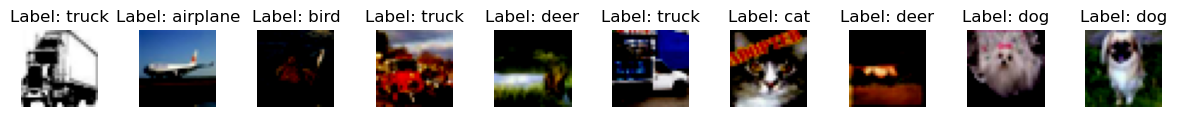

Client 1:


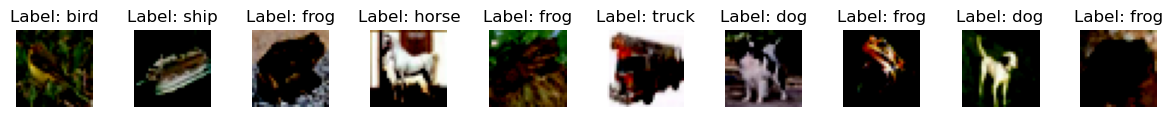

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.cluster import AgglomerativeClustering
import random
from torch import nn, optim
import torch.nn.functional as F
import os
from torchvision import datasets, transforms
from copy import deepcopy
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Set random seed
torch.manual_seed(43)
np.random.seed(43)
device = "cuda" if torch.cuda.is_available() else "cpu"

# CIFAR-10 class labels
mapp = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 
                 'dog', 'frog', 'horse', 'ship', 'truck'], dtype='<U10')

# Define FedAvgCNN model
class FedAvgCNN(nn.Module):
    def __init__(self, in_features=3, num_classes=10, dim=1600):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_features,
                      32,
                      kernel_size=5,
                      padding=0,
                      stride=1,
                      bias=True),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,
                      64,
                      kernel_size=5,
                      padding=0,
                      stride=1,
                      bias=True),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.fc1 = nn.Sequential(
            nn.Linear(dim, 512), 
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Linear(512, num_classes)

    def replace_linear_with_lora(self, rank=4):
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                lora_layer = LoRALinear(module, rank=rank)
                parent = self.model
                if '.' in name:
                    parts = name.split('.')
                    for part in parts[:-1]:
                        parent = getattr(parent, part)
                    setattr(parent, parts[-1], lora_layer)
                else:
                    setattr(parent, name, lora_layer)
                print(f"Replaced {name} with LoRALinear (rank={rank})")
        self.optimizer = optim.Adam([p for p in self.model.parameters() if p.requires_grad], lr=0.001)
        self.is_lora = True

    def forward(self, x):
        if x.dim() == 4 and x.size(1) != self.conv1[0].in_channels:
            x = x.permute(0, 3, 1, 2)
        out = self.conv1(x)
        out = self.conv2(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.fc(out)
        return out

# Define dataset class for loading single .npz file
class CIFAR10Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        """
        Load data from a single .npz file.
        
        Args:
            file_path (str): Path to the .npz file.
            transform: Optional transform to be applied to images.
        """
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File {file_path} not found")
        
        data = np.load(file_path, allow_pickle=True)
        data_dict = data['data'].item()
        
        # Extract images and labels
        self.images = data_dict['x']
        # Ensure images are in [N, H, W, C] format (e.g., [N, 32, 32, 3])
        if self.images.shape[-1] != 3:  # If not already in [H, W, C]
            if len(self.images.shape) == 3:  # [N, H*W*C]
                self.images = self.images.reshape(-1, 32, 32, 3)
            elif len(self.images.shape) == 4 and self.images.shape[1] == 3:  # [N, C, H, W]
                self.images = self.images.transpose(0, 2, 3, 1)  # Convert to [N, H, W, C]
        
        self.labels = data_dict['y']
        self.transform = transform
        
        print(f"Loaded {file_path}: {len(self.images)} samples")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Ensure image is in [H, W, C] format for ToTensor()
        if self.transform:
            image = self.transform(image)

        return image, label

# Define data transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts [H, W, C] to [C, H, W]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB channels
])

# Load client datasets directly from .npz files
data_dir = r"/home/xieyi/project/CZY/PFL-Non-IID-master1/dataset/Cifar10_100/"
N_CLIENTS = 10

client_train_data = []
client_test_data = []

for i in range(N_CLIENTS):
    # Load training data
    train_file = os.path.join(data_dir, 'train', f'{i}.npz')
    train_dataset = CIFAR10Dataset(train_file, transform=transform)
    client_train_data.append(train_dataset)
    
    # Load test data
    test_file = os.path.join(data_dir, 'test', f'{i}.npz')
    test_dataset = CIFAR10Dataset(test_file, transform=transform)
    client_test_data.append(test_dataset)

# Create test dataset for server (concatenate all test data)
test_datasets = [CIFAR10Dataset(os.path.join(data_dir, 'test', f'{i}.npz'), transform=transform)
                 for i in range(N_CLIENTS)]
test_images = np.concatenate([ds.images for ds in test_datasets], axis=0)
test_labels = np.concatenate([ds.labels for ds in test_datasets], axis=0)

class CombinedTestDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

test_dataset = CombinedTestDataset(test_images, test_labels, transform=transform)

# Define custom subset class
class CustomSubset(Subset):
    def __init__(self, dataset, indices, subset_transform=None):
        super().__init__(dataset, indices)
        self.subset_transform = subset_transform

    def __getitem__(self, idx):
        x, y = self.dataset[self.indices[idx]]
        if self.subset_transform:
            x = self.subset_transform(x)
        return x, y

# Define client and server classes
class FederatedTrainingDevice(object):
    def __init__(self, model_fn, data):
        self.model = model_fn().to(device)
        self.data = data
        self.W = {key: value for key, value in self.model.named_parameters()}

    def evaluate(self, loader=None):
        return eval_op(self.model, self.eval_loader if not loader else loader)

class Client(FederatedTrainingDevice):
    def __init__(self, model_fn, optimizer_fn, train_data, test_data, idnum, batch_size=128):
        super().__init__(model_fn, train_data)
        self.optimizer = optimizer_fn(self.model.parameters())

        self.train_data = train_data
        self.test_data = test_data

        self.train_loader = DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.eval_loader = DataLoader(self.test_data, batch_size=batch_size, shuffle=False)

        self.id = idnum

        self.dW = {key: torch.zeros_like(value) for key, value in self.model.named_parameters()}
        self.W_old = {key: torch.zeros_like(value) for key, value in self.model.named_parameters()}

    def synchronize_with_server(self, server):
        copy(target=self.W, source=server.W)

    def compute_weight_update(self, epochs=1, loader=None):
        copy(target=self.W_old, source=self.W)
        self.optimizer.param_groups[0]["lr"] *= 0.99
        train_stats = train_op(self.model, self.train_loader if not loader else loader, self.optimizer, epochs)
        subtract_(target=self.dW, minuend=self.W, subtrahend=self.W_old)
        return train_stats

    def reset(self):
        copy(target=self.W, source=self.W_old)

def mean_without_zeros(arr):
    masked_arr = np.where(arr == 0, np.nan, arr)
    mean_values = np.nanmean(masked_arr, axis=1)
    return mean_values

class ExperimentLogger:
    def log(self, values):
        for k, v in values.items():
            if k not in self.__dict__:
                self.__dict__[k] = [v]
            else:
                self.__dict__[k] += [v]

def highlight_max(s):
    global max_values
    is_max = s == s.max()
    max_values.append(s.max())
    return ['background-color: yellow' if v else '' for v in is_max]

def display_train_stats(res_mean, res_std, cfl_stats, eps_1, eps_2, communication_rounds):
    clear_output(wait=True)

    acc_mean = np.mean(cfl_stats.acc_clients, axis=1)
    print(acc_mean)
    res_mean = acc_mean
    acc_std = np.std(cfl_stats.acc_clients, axis=1)
    print(acc_std)

    res_std = acc_std
    plt.fill_between(cfl_stats.rounds, acc_mean-acc_std, acc_mean+acc_std, alpha=0.5, color="C0")
    plt.plot(cfl_stats.rounds, acc_mean, color="C0")

    if "split" in cfl_stats.__dict__:
        for s in cfl_stats.split:
            plt.axvline(x=s, linestyle="-", color="k", label=r"Split")

    plt.xlabel("Communication Rounds")
    plt.ylabel("Accuracy")

    plt.xlim(0, communication_rounds)
    plt.ylim(0, 1)
    plt.legend()

    plt.xlim(0, communication_rounds)

    plt.show()
    return res_mean, res_std

def train_op(model, loader, optimizer, epochs=1):
    model.train()
    for ep in range(epochs):
        running_loss, samples = 0.0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            loss = torch.nn.CrossEntropyLoss()(model(x), y)
            running_loss += loss.item() * y.shape[0]
            samples += y.shape[0]

            loss.backward()
            optimizer.step()

    print("Running loss:", running_loss)
    print("Samples:", samples)
    return running_loss / samples

def eval_op(model, loader):
    model.eval()
    samples, correct = 0, 0

    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x, y = x.to(device), y.to(device)

            y_ = model(x)
            _, predicted = torch.max(y_.data, 1)

            samples += y.shape[0]
            correct += (predicted == y).sum().item()
    print("Samples:", samples)
    print("Correct:", correct)
    return correct / samples

def copy(target, source):
    for name in target:
        target[name].data = source[name].data.clone()

def subtract_(target, minuend, subtrahend):
    for name in target:
        target[name].data = minuend[name].data.clone() - subtrahend[name].data.clone()

def reduce_add_average(targets, sources):
    for target in targets:
        for name in target:
            tmp = torch.mean(torch.stack([source[name].data for source in sources]), dim=0).clone()
            target[name].data += tmp

def flatten(source):
    return torch.cat([value.flatten() for value in source.values()])

def pairwise_angles(sources):
    angles = torch.zeros([len(sources), len(sources)])
    for i, source1 in enumerate(sources):
        for j, source2 in enumerate(sources):
            s1 = flatten(source1)
            s2 = flatten(source2)
            angles[i, j] = torch.sum(s1 * s2) / (torch.norm(s1) * torch.norm(s2) + 1e-12)
    return angles.numpy()

class Server(FederatedTrainingDevice):
    def __init__(self, model_fn, data):
        super().__init__(model_fn, data)
        self.loader = DataLoader(self.data, batch_size=128, shuffle=False)
        self.model_cache = []

    def select_clients(self, clients, frac=1.0):
        selected_clients = random.sample(clients, int(len(clients) * frac))
        print("Selected clients count:", len(selected_clients))
        return selected_clients

    def aggregate_weight_updates(self, clients):
        reduce_add_average(target=self.W, sources=[client.dW for client in clients])

    def compute_pairwise_similarities(self, clients):
        similarities = pairwise_angles([client.dW for client in clients])
        print("Pairwise similarities shape:", similarities.shape)
        return similarities

    def cluster_clients(self, S):
        clustering = AgglomerativeClustering(affinity="precomputed", linkage="complete").fit(-S)
        print("Cluster labels:", clustering.labels_)
        c1 = np.argwhere(clustering.labels_ == 0).flatten()
        c2 = np.argwhere(clustering.labels_ == 1).flatten()
        print("Cluster 0 size:", len(c1))
        print("Cluster 1 size:", len(c2))
        return c1, c2

    def aggregate_clusterwise(self, client_clusters):
        for cluster in client_clusters:
            reduce_add_average(targets=[client.W for client in cluster],
                               sources=[client.dW for client in cluster])
            print("Aggregated cluster size:", len(cluster))

    def compute_max_update_norm(self, cluster):
        max_norm = np.max([torch.norm(flatten(client.dW)).item() for client in cluster])
        print("Max update norm:", max_norm)
        return max_norm

    def compute_mean_update_norm(self, cluster):
        mean_norm = torch.norm(torch.mean(torch.stack([flatten(client.dW) for client in cluster]), dim=0)).item()
        print("Mean update norm:", mean_norm)
        return mean_norm

    def cache_model(self, idcs, params, accuracies):
        self.model_cache += [(idcs, {name: params[name].data.clone() for name in params}, [accuracies[i] for i in idcs])]
        print("Model cached with indices:", idcs)

# Initialize server and clients
server = Server(FedAvgCNN, test_dataset)
clients = [Client(FedAvgCNN, lambda x: torch.optim.SGD(x, lr=0.001, momentum=0.9), train_data, test_data, idnum=i)
           for i, (train_data, test_data) in enumerate(zip(client_train_data, client_test_data))]

# Visualize data for clients 0 and 1
for client in [clients[0], clients[1]]:
    x, y = next(iter(client.train_loader))
    print("Client {}:".format(client.id))
    plt.figure(figsize=(15, 1))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        # Denormalize for visualization
        img = x[i].permute(1, 2, 0).numpy() * 0.5 + 0.5  # Undo normalization
        img = np.clip(img, 0, 1)  # Ensure values are in [0, 1]
        plt.imshow(img)
        plt.title("Label: {}".format(mapp[y[i].item()]))
        plt.axis('off')
    plt.show()

g_server = deepcopy(server)
g_clients = deepcopy(clients)

In [4]:
# import numpy as np
# import torchvision.utils as vutils
# from copy import deepcopy
# import matplotlib.pyplot as plt

# clients = [Client(ConvNet, lambda x : torch.optim.SGD(x, lr=0.01, momentum=0.9), dat, idnum=i)
#            for i, dat in enumerate(client_data)]

# for client in [clients[0], clients[1]]: #依次输出客户0和客户5的前10个图片数据
#     # x, y = iter(client.train_loader).next()
#     x, y = next(iter(client.train_loader))
#     print("Client {}:".format(client.id))
#     plt.figure(figsize=(15,1))
#     for i in range(10):
#         plt.subplot(1,10,i+1)
#         plt.imshow(x[i,0].numpy().T, cmap="Greys")#x[i, 0] 表示第 i 个图像的第一个通道，i为图片的索引
#         plt.title("Label: {}".format(mapp[y[i].item()]))#标签
#     plt.show()
# server = Server(ConvNet, test_data)


# g_server=deepcopy(server)
# g_clients=deepcopy(clients)

In [5]:
from more_itertools import set_partitions

data_points = list(range(0, 10))

partition_counts = {}

partitions = list(set_partitions(data_points, 2))
print(partitions)

# 将 partitions 转换为01分组
def convert_partitions_to_binary(partitions):
    # 找到集合中的最大索引
    max_index = max(max(p[0] + p[1]) for p in partitions)
    # 初始化一个列表，长度等于最大索引加一，初始值为0
    binary_partitions = []

    # 遍历每个划分
    for partition in partitions:
        # 初始化当前划分的01分组列表
        binary_partition = [0] * (max_index + 1)
        
        # 遍历划分中的每个子集
        for subset_index, subset in enumerate(partition):
            # 遍历子集中的每个元素索引
            for element_index in subset:
                # 将元素的索引设置为子集的索引（0或1）
                binary_partition[element_index] = subset_index
        
        # 将当前划分的01分组添加到列表中
        binary_partitions.append(binary_partition)
    
    return binary_partitions

# 转换并打印01分组
binary_partitions = convert_partitions_to_binary(partitions)
# for binary_partition in binary_partitions:
#     print(binary_partition)

# 根据分区的长度进行排序
sorted_binary_partitions = sorted(binary_partitions, key=lambda x: len(x))
print(sorted_binary_partitions)

[[[0], [1, 2, 3, 4, 5, 6, 7, 8, 9]], [[0, 1], [2, 3, 4, 5, 6, 7, 8, 9]], [[1], [0, 2, 3, 4, 5, 6, 7, 8, 9]], [[0, 1, 2], [3, 4, 5, 6, 7, 8, 9]], [[1, 2], [0, 3, 4, 5, 6, 7, 8, 9]], [[0, 2], [1, 3, 4, 5, 6, 7, 8, 9]], [[2], [0, 1, 3, 4, 5, 6, 7, 8, 9]], [[0, 1, 2, 3], [4, 5, 6, 7, 8, 9]], [[1, 2, 3], [0, 4, 5, 6, 7, 8, 9]], [[0, 2, 3], [1, 4, 5, 6, 7, 8, 9]], [[2, 3], [0, 1, 4, 5, 6, 7, 8, 9]], [[0, 1, 3], [2, 4, 5, 6, 7, 8, 9]], [[1, 3], [0, 2, 4, 5, 6, 7, 8, 9]], [[0, 3], [1, 2, 4, 5, 6, 7, 8, 9]], [[3], [0, 1, 2, 4, 5, 6, 7, 8, 9]], [[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]], [[1, 2, 3, 4], [0, 5, 6, 7, 8, 9]], [[0, 2, 3, 4], [1, 5, 6, 7, 8, 9]], [[2, 3, 4], [0, 1, 5, 6, 7, 8, 9]], [[0, 1, 3, 4], [2, 5, 6, 7, 8, 9]], [[1, 3, 4], [0, 2, 5, 6, 7, 8, 9]], [[0, 3, 4], [1, 2, 5, 6, 7, 8, 9]], [[3, 4], [0, 1, 2, 5, 6, 7, 8, 9]], [[0, 1, 2, 4], [3, 5, 6, 7, 8, 9]], [[1, 2, 4], [0, 3, 5, 6, 7, 8, 9]], [[0, 2, 4], [1, 3, 5, 6, 7, 8, 9]], [[2, 4], [0, 1, 3, 5, 6, 7, 8, 9]], [[0, 1, 4], [2, 3, 5, 6, 7,

In [6]:
# from more_itertools import set_partitions

# data_points = list(range(0, 10))

# unique_binary_partitions = set()

# # 遍历所有可能的划分数量 (从 1 组到 len(data_points) 组)
# for num_partitions in range(1, len(data_points) + 1):
#     partitions = list(set_partitions(data_points, num_partitions))
#     print(f"\n--- {num_partitions} 分组的原始划分 ---")
#     print(partitions)

#     # 将 partitions 转换为分组索引
#     def convert_partitions_to_indexed(partitions):
#         indexed_partitions = []
#         for partition in partitions:
#             indexed_partition = [0] * len(data_points)
#             for group_index, subset in enumerate(partition):
#                 for element_index in subset:
#                     indexed_partition[element_index] = group_index
#             indexed_partitions.append(indexed_partition)
#         return indexed_partitions

#     binary_partitions = convert_partitions_to_indexed(partitions)
#     print(f"--- {num_partitions} 分组的索引 ---")
#     # for bp in binary_partitions:
#     #     print(bp)

#     # 将每个分组的列表转换为元组并添加到集合中，自动去除重复项
#     for bp in binary_partitions:
#         unique_binary_partitions.add(tuple(bp))

# # 将集合中的元组转换回列表
# sorted_unique_binary_partitions = [list(t) for t in sorted(list(unique_binary_partitions))]

# print("\n--- 去除重复分组后的所有唯一索引结果 (按添加顺序排序) ---")
# print(sorted_unique_binary_partitions)

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from copy import deepcopy

list_quanju = []
list_quanju_v = []

def remove_empty_lists(input_list):
    result_list = [sublist for sublist in input_list if sublist]
    return result_list

def deep_equals(list1, list2):
    if len(list1) != len(list2):
        return False
    for i in range(len(list1)):
        if isinstance(list1[i], list) and isinstance(list2[i], list):
            if not deep_equals(list1[i], list2[i]):
                return False
        elif list1[i] != list2[i]:
            return False
    return True

def find_combination_indices(list_of_combinations, target_combination):
    indices = []
    for index, combination in enumerate(list_of_combinations):
        if deep_equals(combination, target_combination) or deep_equals(combination, target_combination[::-1]):
            indices.append(index)
    return indices

def run_federated_learning(server, clients):
    COMMUNICATION_ROUNDS = 2  # 通信轮数
    cluster_indices = [np.arange(len(clients)).astype("int")]
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

    for c_round in range(1, COMMUNICATION_ROUNDS + 1):
        if c_round == 1:
            for client in clients:
                client.synchronize_with_server(server)

        participating_clients = server.select_clients(clients, frac=1.0)
        for client in participating_clients:
            client.compute_weight_update(epochs=1)
            client.reset()

        similarities = server.compute_pairwise_similarities(clients)
        print(f"Round {c_round} Similarities:\n{similarities}")

        client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
        server.aggregate_clusterwise(client_clusters)

        acc_clients = [client.evaluate() for client in clients]
        print(f"Round {c_round} Average Accuracy: {np.mean(acc_clients)}")

        if c_round == 2:
            final_clients = deepcopy(clients)
            return final_clients, similarities

    return clients, similarities # 理论上不会执行到这里

def fitness(individual, final_clients, server):
    print("*")
    indexes_of_ones = [index for index, value in enumerate(individual) if value == 0]
    indexes_of_zeros = [index for index, value in enumerate(individual) if value == 1]
    cluster_indices = [indexes_of_ones, indexes_of_zeros]
    cluster_indices1 = [indexes_of_zeros, indexes_of_ones]
    index = find_combination_indices(list_quanju, cluster_indices)
    index1 = find_combination_indices(list_quanju, cluster_indices1)

    if index or index1:
        existing_index = index[0] if index else index1[0]
        return list_quanju_v[existing_index], 0
    if [] in cluster_indices:
        return 0, 0

    print(f"Evaluating Cluster Indices: {cluster_indices}")
    clients = deepcopy(final_clients)
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
    server.aggregate_clusterwise(client_clusters)
    acc_clients = [client.evaluate() for client in clients]
    print("acc_clients",acc_clients)
    mean_accuracy = np.mean(acc_clients)
    std_accuracy = np.std(acc_clients)
    list_quanju.append(cluster_indices)
    list_quanju_v.append(mean_accuracy)
    print(f"Accuracy for {individual}: {acc_clients}, Mean: {mean_accuracy}, Std: {std_accuracy}")
    return mean_accuracy, std_accuracy

def generate_binary_partitions(n):
    for i in range(2**n):
        binary = bin(i)[2:].zfill(n)
        yield [int(bit) for bit in binary]

def traversal_algorithm(gene_size, final_clients, server):
    results = []
    sorted_binary_partitions = sorted(list(generate_binary_partitions(gene_size)))

    for individual in sorted_binary_partitions:
        mean_acc, std_acc = fitness(individual, final_clients, server)
        print(f"Individual: {individual}, Mean: {mean_acc}, Std: {std_acc}")
        results.append((individual, mean_acc, std_acc))

    if results:
        top_5 = sorted(results, key=lambda x: x[1], reverse=True)[:3]
        best_individual_with_stats = min(top_5, key=lambda x: x[2])
        best_individual = best_individual_with_stats[0]
        best_fitness = best_individual_with_stats[1]
        best_std = best_individual_with_stats[2]
        print(f"Best Individual (Top 5): {best_individual}, Mean: {best_fitness}, Std: {best_std}")
        return best_individual
    else:
        return None

if __name__ == "__main__":
    num_clients = 10
    g_server = deepcopy(server)
    g_clients = deepcopy(clients)

    # 运行联邦学习的第一阶段
    final_clients, similarities = run_federated_learning(deepcopy(g_server), deepcopy(g_clients))

    # 在第二轮结束后，使用最终的客户端状态寻找最佳分组
    if final_clients:
        gene_size = len(final_clients)
        best_individual = traversal_algorithm(gene_size, final_clients, deepcopy(g_server))

        if best_individual is not None:
            print(f"Best Individual (Overall): {best_individual}, Fitness: {fitness(best_individual, final_clients, deepcopy(g_server))}")
            fenzu_PIFCA = best_individual
            print(f"fenzu_PIFCA: {fenzu_PIFCA}")
        else:
            print("No valid client combinations found.")
    else:
        print("Federated learning run failed to return final client states.")

Selected clients count: 10
Running loss: 12216.365911006927
Samples: 5313
Running loss: 11779.203852176666
Samples: 5126
Running loss: 13296.899753808975
Samples: 5795
Running loss: 11688.088429450989
Samples: 5094
Running loss: 12667.73591041565
Samples: 5521
Running loss: 12311.103677749634
Samples: 5363
Running loss: 12394.849323511124
Samples: 5391
Running loss: 12584.119997024536
Samples: 5487
Running loss: 12687.133853912354
Samples: 5521
Running loss: 12361.595486879349
Samples: 5385
Pairwise similarities shape: (10, 10)
Round 1 Similarities:
[[1.         0.8363172  0.8486885  0.7843803  0.75840163 0.90751886
  0.70249474 0.7703535  0.8681454  0.7484071 ]
 [0.8363172  1.         0.79971224 0.67937756 0.8140608  0.88313144
  0.88444614 0.7138946  0.8527823  0.6986321 ]
 [0.8486885  0.79971224 1.         0.80640984 0.8615896  0.8354505
  0.82511246 0.81325096 0.889624   0.8070665 ]
 [0.7843803  0.67937756 0.80640984 1.         0.7926864  0.8412167
  0.7031537  0.8576556  0.8653137

In [8]:
# import numpy as np
# import pandas as pd
# from matplotlib import pyplot as plt

# def remove_empty_lists(input_list):
#     result_list = [sublist for sublist in input_list if sublist]
#     return result_list


# def run_federated_learning(server, clients):
#     zuhe=[]
#     zuhe_v=[]


#     COMMUNICATION_ROUNDS = 2  #通信轮数

#     cluster_indices_new = []

#     cluster_indices = [np.arange(len(clients)).astype("int")] 
#     client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

#     for c_round in range(1, COMMUNICATION_ROUNDS+1):#对于每一个通信轮次
#         if c_round == 1: #在第一个通信轮次中将服务器的梯度同步到每一个客户机中
#             for client in clients:
#                 client.synchronize_with_server(server) #将server模型参数下发到client

#         participating_clients = server.select_clients(clients, frac=1.0)



#         for client in participating_clients:
#             train_stats = client.compute_weight_update(epochs=1)
#             client.reset()

#         similarities = server.compute_pairwise_similarities(clients)
#         print(similarities)

#         # if  (c_round%1000==0 and  c_round>=30) or c_round==1 or c_round==2:
#         #     if c_round==1 :
#         #         clusters_res=[[0,1,2,3,4,5,6,7,8,9]]
#         #     if c_round==2 :
#         #         clusters_res=[[0,1,2,3,4],[5,6,7,8,9]]
#         #     cluster_indices_new=clusters_res
        
#         # if cluster_indices_new!=[]:
#         #     cluster_indices = cluster_indices_new #集合更新
#         #     cluster_indices = remove_empty_lists(cluster_indices)

#         # print(cluster_indices)

#         # if c_round==2 :
#         #     # W_list=[]
#         #     dW_list=[]
#         #     # model_list=[]
#         #     # optimizer_list=[]
#         #     for client in clients:
#         #         # W_list.append(deepcopy(client.W))
#         #         dW_list.append(deepcopy(client.dW))
#         #         # model_list.append(deepcopy(client.model))
#         #         # optimizer_list.append(deepcopy(client.optimizer))


#         if c_round==2 :
#             a=deepcopy(clients)
#             print(a)

#         client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]  #映射分组
        
#         server.aggregate_clusterwise(client_clusters) #获取每组的平均梯度和权重
        
#         acc_clients = [client.evaluate() for client in clients] #获取每个用户的准确率，构建成一个list

#         print(np.mean(acc_clients))

#         # if c_round==2 :
#         #     b=deepcopy(clients)

#         if c_round==2:
#             break

#             # for comb in partitions:
#             #     clients=deepcopy(a)
#             #     print("*")
#             #     cluster_indices=comb
#             #     print(cluster_indices)
#             #     client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]  #映射分组
#             #     server.aggregate_clusterwise(client_clusters) #获取每组的平均梯度和权重
#             #     acc_clients = [client.evaluate() for client in clients] #获取每个用户的准确率，构建成一个list
#             #     print(np.mean(acc_clients))
#             #     zuhe.append(comb)
#             #     zuhe_v.append(np.mean(acc_clients))
#             #     break
    
#     return a,similarities

# for i in range(1):
#     server=deepcopy(g_server)
#     clients=deepcopy(g_clients)
#     a,similarities=run_federated_learning(server,clients)


# # import pickle


# # lists_to_pickle = [zuhe, zuhe_v]

# # with open('lists.pkl', 'wb') as file:
# #     pickle.dump(lists_to_pickle, file)

In [9]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# import numpy as np

# similarity_matrix = np.array(similarities)  # 确保相似性矩阵已经正确定义和初始化
# # 尝试不同的聚类数目
# best_num_clusters = 2  # 假设2为起始聚类数目
# best_silhouette = -np.inf

# for n_clusters in range(2, 10):  # 尝试从2到9个聚类
#     kmeans = KMeans(n_clusters=n_clusters, random_state=0)
#     kmeans.fit(similarity_matrix)
    
#     # 计算轮廓系数
#     silhouette_avg = silhouette_score(similarity_matrix, kmeans.labels_)
    
#     # 记录最优的聚类数目
#     if silhouette_avg > best_silhouette:
#         best_silhouette = silhouette_avg
#         best_num_clusters = n_clusters
#         best_labels = kmeans.labels_  # 保存当前最优的聚类标签

# print(f"最优的聚类数目是: {best_num_clusters}")

# # 假设data_points是包含用户标号的列表
# data_points = list(range(len(similarity_matrix)))  # 这里假设用户标号是0到相似性矩阵行数-1

# # 输出每个用户所属的聚类标号
# clustered_data_points = {}
# for user, label in zip(data_points, best_labels):
#     clustered_data_points.setdefault(label, []).append(user)

# print("用户所属聚类标号:")

# best_clusters=[]
# for cluster_id, users in clustered_data_points.items():
#     print(f"聚类 {cluster_id}: 用户标号 {users}")
#     best_clusters.append(users)
# print(best_clusters)


In [10]:
# import numpy as np
# from copy import deepcopy

# list_quanju = []
# list_quanju_v = []

# def deep_equals(list1, list2):
#     if len(list1) != len(list2):
#         return False
#     for i in range(len(list1)):
#         if isinstance(list1[i], list) and isinstance(list2[i], list):
#             if not deep_equals(list1[i], list2[i]):
#                 return False
#         elif list1[i] != list2[i]:
#             return False
#     return True

# def find_combination_indices(list_of_combinations, target_combination):
#     indices = []
#     for index, combination in enumerate(list_of_combinations):
#         if deep_equals(combination, target_combination) or deep_equals(combination, target_combination[::-1]):
#             indices.append(index)
#     return indices

# def fitness(individual):
#     print("*")
#     indexes_of_ones = [index for index, value in enumerate(individual) if value == 0]
#     indexes_of_zeros = [index for index, value in enumerate(individual) if value == 1]
#     cluster_indices = [indexes_of_ones, indexes_of_zeros]
#     cluster_indices1 = [indexes_of_zeros, indexes_of_ones]
#     index = find_combination_indices(list_quanju, cluster_indices)
#     index1 = find_combination_indices(list_quanju, cluster_indices1)
    
#     if index or index1:
#         return list_quanju_v[index[0]] if index else list_quanju_v[index1[0]]
#     if [] in cluster_indices:
#         return 0
#     print(cluster_indices)
#     clients = deepcopy(a)
#     client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
#     server.aggregate_clusterwise(client_clusters)
#     acc_clients = [client.evaluate() for client in clients]
#     list_quanju.append(cluster_indices)
#     list_quanju_v.append(np.mean(acc_clients))
#     print("acc_clients", acc_clients)
#     return np.mean(acc_clients) - np.std(acc_clients)

# def traversal_algorithm(gene_size):
#     best_individual = None
#     best_fitness = float('-inf')
    
#     for individual in sorted_binary_partitions:
#         current_fitness = fitness(individual)
#         print(f"Individual: {individual}, Fitness: {current_fitness}")
#         if current_fitness > best_fitness:
#             best_fitness = current_fitness
#             best_individual = individual
    
#     return best_individual

# gene_size = 10
# best_individual = traversal_algorithm(gene_size)
# print(f"Best Individual: {best_individual}, Fitness: {fitness(best_individual)}")
# fenzu_PIFCA = best_individual
# print(fenzu_PIFCA)

In [11]:
# import numpy as np
# from copy import deepcopy

# list_quanju = []
# list_quanju_v = []

# def deep_equals(list1, list2):
#     if len(list1) != len(list2):
#         return False
#     for i in range(len(list1)):
#         if isinstance(list1[i], list) and isinstance(list2[i], list):
#             if not deep_equals(list1[i], list2[i]):
#                 return False
#         elif list1[i] != list2[i]:
#             return False
#     return True

# def find_combination_indices(list_of_combinations, target_combination):
#     indices = []
#     for index, combination in enumerate(list_of_combinations):
#         if deep_equals(combination, target_combination) or deep_equals(combination, target_combination[::-1]):
#             indices.append(index)
#     return indices

# def fitness(individual):
#     print("*")
#     indexes_of_ones = [index for index, value in enumerate(individual) if value == 0]
#     indexes_of_zeros = [index for index, value in enumerate(individual) if value == 1]
#     cluster_indices = [indexes_of_ones, indexes_of_zeros]
#     cluster_indices1 = [indexes_of_zeros, indexes_of_ones]
#     index = find_combination_indices(list_quanju, cluster_indices)
#     index1 = find_combination_indices(list_quanju, cluster_indices1)
    
#     if index or index1:
#         return list_quanju_v[index[0]] if index else list_quanju_v[index1[0]]
#     if [] in cluster_indices:
#         return 0
#     print(cluster_indices)
#     clients = deepcopy(a)
#     client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
#     server.aggregate_clusterwise(client_clusters)
#     acc_clients = [client.evaluate() for client in clients]
#     list_quanju.append(cluster_indices)
#     list_quanju_v.append(np.mean(acc_clients))
#     print("acc_clients", acc_clients)
#     return np.mean(acc_clients), np.std(acc_clients)

# def traversal_algorithm(gene_size):
#     results = []
    
#     for individual in sorted_binary_partitions:
#         mean_acc, std_acc = fitness(individual)
#         print(f"Individual: {individual}, Mean: {mean_acc}, Std: {std_acc}")
#         results.append((individual, mean_acc, std_acc))
    
#     # Sort by mean in descending order and take top 5
#     top_5 = sorted(results, key=lambda x: x[1], reverse=True)[:5]
    
#     # Among top 5, find the one with minimum std
#     best_individual = min(top_5, key=lambda x: x[2])[0]
    
#     return best_individual

# gene_size = 10
# best_individual = traversal_algorithm(gene_size)
# print(f"Best Individual: {best_individual}, Fitness: {fitness(best_individual)}")
# fenzu_PIFCA = best_individual
# print(fenzu_PIFCA)

In [12]:
# import random

# list_quanju=[]
# list_quanju_v=[]
# # 适应度函数：计算个体中1的总数

# def deep_equals(list1, list2):
#     if len(list1) != len(list2):
#         return False
#     for i in range(len(list1)):
#         if isinstance(list1[i], list) and isinstance(list2[i], list):
#             if not deep_equals(list1[i], list2[i]):
#                 return False
#         elif list1[i] != list2[i]:
#             return False
#     return True

# def find_combination_indices(list_of_combinations, target_combination):
#     indices = []
#     for index, combination in enumerate(list_of_combinations):
#         if deep_equals(combination, target_combination) or deep_equals(combination, target_combination[::-1]):
#             indices.append(index)
#     return indices

# def fitness(individual):
#     print("*")
#     indexes_of_ones = [index for index, value in enumerate(individual) if value == 0]
#     indexes_of_zeros = [index for index, value in enumerate(individual) if value == 1]
#     cluster_indices=[indexes_of_ones,indexes_of_zeros]
#     cluster_indices1=[indexes_of_zeros,indexes_of_ones]
#     index=find_combination_indices(list_quanju,cluster_indices)
#     index1=find_combination_indices(list_quanju,cluster_indices1)
    
#     if index!=[] or index1!=[]:
#         if index!=None:
#             # print(index)
#             return list_quanju_v[index[0]]
#         if index1!=None:
#             return list_quanju_v[index1[0]]
#     if [] in cluster_indices:
#         return 0
#     print(cluster_indices)
#     clients=deepcopy(a)
#     client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
#     server.aggregate_clusterwise(client_clusters)
#     acc_clients = [client.evaluate() for client in clients]
#     list_quanju.append(cluster_indices)
#     list_quanju_v.append(np.mean(acc_clients))
#     print("acc_clients",acc_clients)
#     #-np.std(acc_clients)
#     return np.mean(acc_clients)-np.std(acc_clients)

# import random

# def selection_e(population, fitnesses, elite_count=3):
#     # 精英策略：直接选择精英个体
#     # 根据适应度对个体和适应度进行排序
#     sorted_population_fitness = sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True)
    
#     # 选择适应度最高的 elite_count 个精英个体
#     elite_individuals = sorted_population_fitness[:elite_count]
    
#     # 返回精英个体列表
#     return [individual for individual, _ in elite_individuals]

# def check_last_five(max_fitness_list):
#     # 检查列表长度是否至少为5，如果不是，则无法比较后五个元素
#     if len(max_fitness_list) < 7:
#         return False
    
#     # 获取列表的最后五个元素
#     last_five = max_fitness_list[-7:]
    
#     # 检查最后五个元素是否全部相同
#     if all(x == last_five[0] for x in last_five):
#         return True
#     else:
#         return False
    
# def selection(population, fitnesses, elite_count=10):
#     # 精英策略：直接选择精英个体
#     # 根据适应度对个体和适应度进行排序
#     sorted_population_fitness = sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True)
    
#     # 选择适应度最高的 elite_count 个精英个体
#     elite_individuals = sorted_population_fitness[:elite_count]
    
#     # 返回精英个体列表
#     return random.choice(elite_individuals)[0]

# # 交叉（杂交）函数
# def crossover(ind1, ind2):
#     size = len(ind1)
#     crossover_point = random.randint(1, size - 1)
#     child1 = ind1[:crossover_point] + ind2[crossover_point:]
#     child2 = ind2[:crossover_point] + ind1[crossover_point:]
#     return child1, child2

# # 变异函数
# def mutate(individual, mutation_rate):
#     for i in range(len(individual)):
#         if random.random() < mutation_rate:
#             individual[i] = 1 - individual[i]
#     return individual

# # 初始化种群
# # def init_population(pop_size, gene_size):
# #     return [[random.randint(0, 1) for _ in range(gene_size)] for _ in range(pop_size*4)]

# # sorted_binary_partitions

# def init_population(pop_size,gene_size):
#     pop_size=pop_size*2
#     sampled_individuals = []
    
#     while len(sampled_individuals) < pop_size:
#         sampled_individuals.append(random.choice(sorted_binary_partitions))
    
#     return sampled_individuals

# # 遗传算法主函数
# def genetic_algorithm(gene_size, pop_size, generations, mutation_rate):
#     max_fitness_list=[]
#     population = init_population(pop_size, gene_size)

#     for generation in range(generations):
#         # 计算适应度
        
#         fitnesses = [fitness(individual) for individual in population]

#         # 选择和生成新的种群
#         new_population = []
#         for _ in range((pop_size-4) // 2):
#             # 选择两个个体进行交叉
#             parent1 = selection(population, fitnesses)
#             parent2 = selection(population, fitnesses)
#             child1, child2 = crossover(parent1, parent2)

#             # 变异
#             child1 = mutate(child1, mutation_rate)
#             child2 = mutate(child2, mutation_rate)

#             new_population.extend([child1, child2])

#         # 替换旧种群
#         new_population.extend(selection_e(population,fitnesses))
#         population = new_population

#         # 打印当前最佳适应度
#         max_fitness = max(fitnesses)
#         print(f"Generation {generation}: Max Fitness = {max_fitness}")
#         max_fitness_list.append(max_fitness)
#         if check_last_five(max_fitness_list) :
#             # and generation>=int(0.1*generations)
#             break

#     return max(population, key=fitness)
# # 参数设置
# gene_size = 10  # 基因长度
# pop_size = 50   # 种群大小
# generations = 100  # 迭代次数
# mutation_rate = 0.01  # 变异率


# best_individual_list=[]
# F_best_individual_list=[]
# for i in range(1):
#     best_individual = genetic_algorithm(gene_size, pop_size, generations, mutation_rate)
#     best_individual_list.append(best_individual)
#     print(f"Best Individual: {best_individual}, Fitness: {fitness(best_individual)}")
#     F_best_individual_list.append(fitness(best_individual))

# fenzu_PIFCA=best_individual_list[F_best_individual_list.index(max(F_best_individual_list))]
# print(fenzu_PIFCA)

In [13]:
# import random


# # fenzu_PIFCA=[1, 1, 0, 0, 0, 1, 1, 1, 1, 1]

# def deep_equals(list1, list2):
#     if len(list1) != len(list2):
#         return False
#     for i in range(len(list1)):
#         if isinstance(list1[i], list) and isinstance(list2[i], list):
#             if not deep_equals(list1[i], list2[i]):
#                 return False
#         elif list1[i] != list2[i]:
#             return False
#     return True

# def find_combination_indices(list_of_combinations, target_combination):
#     indices = []
#     for index, combination in enumerate(list_of_combinations):
#         if deep_equals(combination, target_combination) or deep_equals(combination, target_combination[::-1]):
#             indices.append(index)
#     return indices


# def f(individual):
#     print("*")
#     indexes_of_ones = [index for index, value in enumerate(individual) if value == 0]
#     indexes_of_zeros = [index for index, value in enumerate(individual) if value == 1]
#     cluster_indices=[indexes_of_ones,indexes_of_zeros]
#     cluster_indices1=[indexes_of_zeros,indexes_of_ones]
#     index=find_combination_indices(list_quanju,cluster_indices)
#     index1=find_combination_indices(list_quanju,cluster_indices1)
    
#     if index!=[] or index1!=[]:
#         if index!=None:
#             # print(index)
#             return list_quanju_v[index[0]]
#         if index1!=None:
#             return list_quanju_v[index1[0]]
#     if [] in cluster_indices:
#         return 0
#     print(cluster_indices)
#     clients=deepcopy(a)
#     client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
#     server.aggregate_clusterwise(client_clusters)
#     acc_clients = [client.evaluate() for client in clients]
#     list_quanju.append(cluster_indices)
#     list_quanju_v.append(np.mean(acc_clients))
#     return np.mean(acc_clients)

# def fitness(individual,cu,cu_bu):
#     chars_list=cu
#     print("*")
#     indexes_of_zeros = [char for idx, char in enumerate(chars_list) if individual[idx] == 0]
#     indexes_of_ones = [char for idx, char in enumerate(chars_list) if individual[idx] == 1]
#     cluster_indices=[indexes_of_ones,indexes_of_zeros]
#     cluster_indices1=[indexes_of_zeros,indexes_of_ones]
#     index=find_combination_indices(list_quanju,cluster_indices)
#     # print(index)
#     index1=find_combination_indices(list_quanju,cluster_indices1)
#     # print(index1)
#     if [] in cluster_indices:
#         return 0
#     if index!=[] or index1!=[]:
#         if index!=None:
#             return list_quanju_v[index[0]]
#         if index1!=None:
#             return list_quanju_v[index1[0]]
#     print(cluster_indices)
#     list_quanju.append([indexes_of_ones,indexes_of_zeros])
#     print(len(list_quanju))
#     cluster_indices.extend(cu_bu)
#     clients=deepcopy(a)
#     client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
#     server.aggregate_clusterwise(client_clusters)
#     acc_clients = [client.evaluate() for client in clients]
#     list_quanju_v.append(np.mean(acc_clients))
#     print("acc_clients",acc_clients)
#     return np.mean(acc_clients)

# import random

# def selection_e(population, fitnesses, elite_count=3):
#     # 精英策略：直接选择精英个体
#     # 根据适应度对个体和适应度进行排序
#     sorted_population_fitness = sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True)
    
#     # 选择适应度最高的 elite_count 个精英个体
#     elite_individuals = sorted_population_fitness[:elite_count]
    
#     # 返回精英个体列表
#     return [individual for individual, _ in elite_individuals]

# def check_last_five(max_fitness_list):
#     # 检查列表长度是否至少为5，如果不是，则无法比较后五个元素
#     if len(max_fitness_list) < 7:
#         return False
    
#     # 获取列表的最后五个元素
#     last_five = max_fitness_list[-7:]
    
#     # 检查最后五个元素是否全部相同
#     if all(x == last_five[0] for x in last_five):
#         return True
#     else:
#         return False
    
# def selection(population, fitnesses, elite_count=10):
#     # 精英策略：直接选择精英个体
#     # 根据适应度对个体和适应度进行排序
#     sorted_population_fitness = sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True)
    
#     # 选择适应度最高的 elite_count 个精英个体
#     elite_individuals = sorted_population_fitness[:elite_count]
    
#     # 返回精英个体列表
#     return random.choice(elite_individuals)[0]

# # 交叉（杂交）函数
# def crossover(ind1, ind2):
#     size = len(ind1)
#     if size<1:
#         print("+++")
#         print(ind1)
#         print(ind2)
#     crossover_point = random.randint(1, size - 1)
#     child1 = ind1[:crossover_point] + ind2[crossover_point:]
#     child2 = ind2[:crossover_point] + ind1[crossover_point:]
#     return child1, child2

# # 变异函数
# def mutate(individual, mutation_rate):
#     for i in range(len(individual)):
#         if random.random() < mutation_rate:
#             individual[i] = 1 - individual[i]
#     return individual

# # 初始化种群
# def init_population(pop_size, gene_size):
#     return [[random.randint(0, 1) for _ in range(gene_size)] for _ in range(pop_size*4)]

# # sorted_binary_partitions

# # def init_population(pop_size,gene_size):
# #     pop_size=pop_size*2
# #     sampled_individuals = []
    
# #     while len(sampled_individuals) < pop_size:
# #         sampled_individuals.append(random.choice(sorted_binary_partitions))
    
# #     return sampled_individuals

# # 遗传算法主函数
# def genetic_algorithm(gene_size, pop_size, generations, mutation_rate,cu,cu_bu):
#     max_fitness_list=[]
#     population = init_population(pop_size, gene_size)
#     for generation in range(generations):
#         # 计算适应度
#         fitnesses = [fitness(individual,cu,cu_bu) for individual in population]
#         # 选择和生成新的种群
#         new_population = []
#         for _ in range((pop_size-3) // 2):
#             # 选择两个个体进行交叉
            
#             parent1 = selection(population, fitnesses)
#             parent2 = selection(population, fitnesses)
#             # print(population)
#             child1, child2 = crossover(parent1, parent2)

#             # 变异
#             child1 = mutate(child1, mutation_rate)
#             child2 = mutate(child2, mutation_rate)

#             new_population.extend([child1, child2])

#         # 替换旧种群
#         new_population.extend(selection_e(population,fitnesses))
#         population = new_population

#         # 打印当前最佳适应度
#         max_fitness = max(fitnesses)
#         print(f"Generation {generation}: Max Fitness = {max_fitness}")
#         max_fitness_list.append(max_fitness)
#         if check_last_five(max_fitness_list) :
#             # and generation>=int(0.1*generations)
#             break

#     return max(population, key=lambda individual: fitness(individual, cu, cu_bu))


# tmp_1=[]
# while tmp_1!=fenzu_PIFCA:
#     indexes_of_ones = [index for index, value in enumerate(fenzu_PIFCA) if value == 0]
#     indexes_of_zeros = [index for index, value in enumerate(fenzu_PIFCA) if value == 1]
#     cluster_indices=[indexes_of_ones,indexes_of_zeros]
#     tmp_1=cluster_indices
#     cu_base=cluster_indices
#     zuihao_list=[]
#     zuihao_list.append(cu_base)
#     for cu in range(len(cu_base)):
#         list_quanju=[]
#         list_quanju_v=[]
#         gene_size = len(cu_base[cu])  # 基因长度
#         print(gene_size)
#         pop_size = 50   # 种群大小
#         generations = 100  # 迭代次数
#         mutation_rate = 0.01  # 变异率
#         cu_bu = [sub_list for j, sub_list in enumerate(cu_base) if j != cu]
#         best_individual_list=[]
#         F_best_individual_list=[]
#         for i in range(1):
#             best_individual = genetic_algorithm(gene_size, pop_size, generations, mutation_rate,cu_base[cu],cu_bu)
#             best_individual_list.append(best_individual)
#             print(f"Best Individual: {best_individual}, Fitness: {fitness(best_individual,cu_base[cu],cu_bu)}")
#             F_best_individual_list.append(fitness(best_individual,cu_base[cu],cu_bu))
#         fenzu_PIFCA=best_individual_list[F_best_individual_list.index(max(F_best_individual_list))]
#         print(fenzu_PIFCA)
#         indexes_of_zeros = [char for idx, char in enumerate(cu_base[cu]) if fenzu_PIFCA[idx] == 0]
#         indexes_of_ones = [char for idx, char in enumerate(cu_base[cu]) if fenzu_PIFCA[idx] == 1]
#         tmp=[indexes_of_zeros,indexes_of_ones]
#         tmp.extend(cu_bu)
#         zuihao_list.append(tmp)
#     print(max(zuihao_list, key=lambda individual: f(individual)))
#     fenzu_PIFCA=max(zuihao_list, key=lambda individual: f(individual))
#     best_clusters=fenzu_PIFCA
#     print("tmp:",tmp_1,"fenzu_PIFCA",fenzu_PIFCA)

#     # while n<best_num_clusters:
#     #     indexes_of_ones = [index for index, value in enumerate(fenzu_PIFCA) if value == 0]
#     #     indexes_of_zeros = [index for index, value in enumerate(fenzu_PIFCA) if value == 1]
#     #     cluster_indices=[indexes_of_ones,indexes_of_zeros]
#     #     cu_base=cluster_indices
#     #     zuihao_list=[]
#     #     zuihao_list.append(cu_base)
#     #     for cu in range(len(cu_base)):
#     #         list_quanju=[]
#     #         list_quanju_v=[]
#     #         gene_size = len(cu_base[cu])  # 基因长度
#     #         print(gene_size)
#     #         pop_size = 20   # 种群大小
#     #         generations = 30  # 迭代次数
#     #         mutation_rate = 0.01  # 变异率
#     #         cu_bu = [sub_list for j, sub_list in enumerate(cu_base) if j != cu]
#     #         best_individual_list=[]
#     #         F_best_individual_list=[]
#     #         for i in range(1):
#     #             best_individual = genetic_algorithm(gene_size, pop_size, generations, mutation_rate,cu_base[cu],cu_bu)
#     #             best_individual_list.append(best_individual)
#     #             print(f"Best Individual: {best_individual}, Fitness: {fitness(best_individual,cu_base[cu],cu_bu)}")
#     #             F_best_individual_list.append(fitness(best_individual,cu_base[cu],cu_bu))
#     #         fenzu_PIFCA=best_individual_list[F_best_individual_list.index(max(F_best_individual_list))]
#     #         print(fenzu_PIFCA)
#     #         indexes_of_zeros = [char for idx, char in enumerate(cu_base[cu]) if fenzu_PIFCA[idx] == 0]
#     #         indexes_of_ones = [char for idx, char in enumerate(cu_base[cu]) if fenzu_PIFCA[idx] == 1]
#     #         tmp=[indexes_of_zeros,indexes_of_ones]
#     #         tmp.extend(cu_bu)
#     #         zuihao_list.append(tmp)
#     #     print(max(zuihao_list, key=lambda individual: f(individual)))
#     #     fenzu_PIFCA=max(zuihao_list, key=lambda individual: f(individual))
#     #     best_clusters=fenzu_PIFCA
#     #     n=n+1